<a href="https://colab.research.google.com/github/troncosofranco/computer-vision/blob/main/Seed_counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem statement
The agricultural sector, particularly those engaged in crop production, often face significant challenges related to the efficient counting and quality control of seeds. These challenges can directly influence their operational effectiveness, production rate, and subsequently, their economic outcomes. The manual counting and quality inspection of seeds is time-consuming. Additionally, identifying broken seeds during the manual inspection process is critical because the germination rate of such seeds is typically lower, which impacts overall crop yield.

The development of an algorithm that accurately counts both entire and broken seeds would resolve these issues, improving efficiency and accuracy in seed counting, while also providing valuable quality control information that can enhance agricultural productivity.

#1. Import modules

In [1]:
import cv2  
import cv2 as cv 
import numpy as np 
from matplotlib import pyplot as plt 

#Colab not support cv2.imshow method thus
from google.colab.patches import cv2_imshow  

from PIL import Image 
from numpy import asarray 

import matplotlib.image as mpimg

# Image processing.
from scipy import ndimage

# Import filters, features, measures and color from skimage
from skimage import filters, feature, measure, color

#Import Watershed for touching Grains separation
from skimage.segmentation import watershed


#2. Load image

In [2]:
# Show image 
def show(image,x=25,y=7):
  img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(x,y))
  plt.imshow(img)

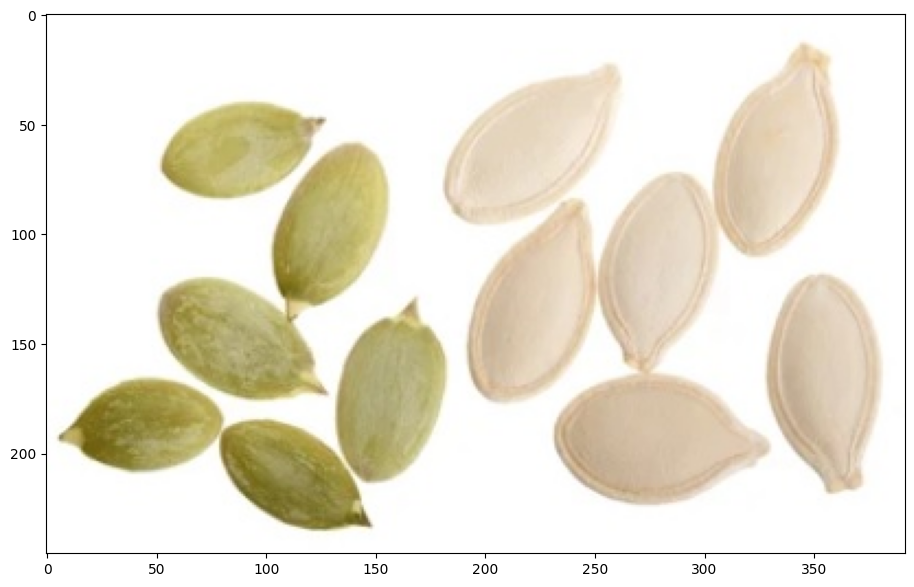

In [3]:
#Load Image
img = cv2.imread("seeds.jpg")
show(img)

#3. Counting function

In [37]:
def counting(image,f1=230,f2=255,area_broken=1):
  img = cv2.imread(image)
  img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  grayscale_Image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  ret, thresh_img = cv2.threshold(grayscale_Image, f1, f2,cv2.THRESH_BINARY)
  #show(thresh_img)

  # Noise removal
  kernel = np.ones((1),np.uint8)
  clear_image = cv2.morphologyEx(thresh_img,cv2.MORPH_OPEN, kernel, iterations=1)
  clear_image = cv2.bitwise_not(clear_image)

  #show(clear_image)

  label_image = clear_image.copy()
  label_count = 0

  # Get height and width
  rows, cols = label_image.shape

  # Looping through each pixel of image
  for j in range(rows):
      for i in range(cols):
          pixel = label_image[j, i]

          #0: Black pixel /255: White pixel
          
          if 255 == pixel:
              label_count += 1

              # FloodFill method: Backgroud filling for contoured grain couting.
              cv.floodFill(label_image, None, (i, j), label_count)

  # Countours method: seed grains counting
  contours, hierarchy = cv.findContours(clear_image, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  output_contour = cv.cvtColor(clear_image, cv.COLOR_GRAY2BGR)
  cv.drawContours(output_contour, contours, -1, (0, 0, 255), 2)
  
  cv2_imshow(output_contour)

  # distance_transform_edt: Determine the distance from non-zero 
  dist_trans = ndimage.distance_transform_edt(clear_image)

  # peak_local_max function: Getting coordinates of local peaks in an image.
  local_max = feature.peak_local_max(dist_trans, min_distance=23)


  local_max_mask = np.zeros(dist_trans.shape, dtype=bool)
  local_max_mask[tuple(local_max.T)] = True

  # Watershed algorithm
  labels = watershed(-dist_trans, measure.label(local_max_mask), mask=clear_image) # separate merged corns

  #label2rgb function
  plt.figure(figsize=(30,10))
  plt.imshow(color.label2rgb(labels, bg_label=0))
  

  # Broken seed counts
  count = []

  for x in contours:

    area = cv.contourArea(x)
    if area < area_broken : # contourn area
      count.append(x)

  print("Detected contours:", len(contours))
  print("Seeds counting : %d" % labels.max())
  print("Total broken seeds: ",len(count))

  return

#4. Test
##4.1. Sunflower

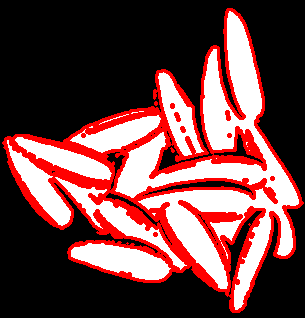

Detected contours: 308
Seeds counting : 16
Total broken seeds:  0


(None, None, None)

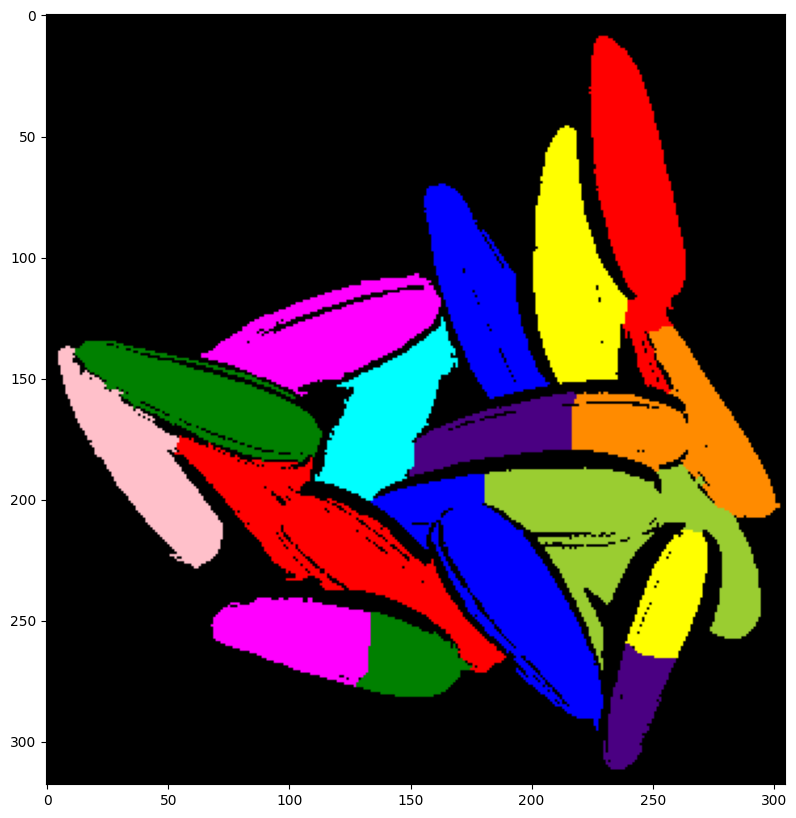

In [36]:
counting('sunflower.jpg',165,255,0)

#4.2. Seeds

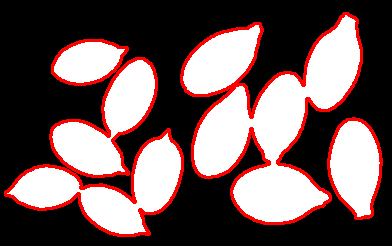

Detected contours: 7
Seeds counting : 12
Total broken seeds:  0


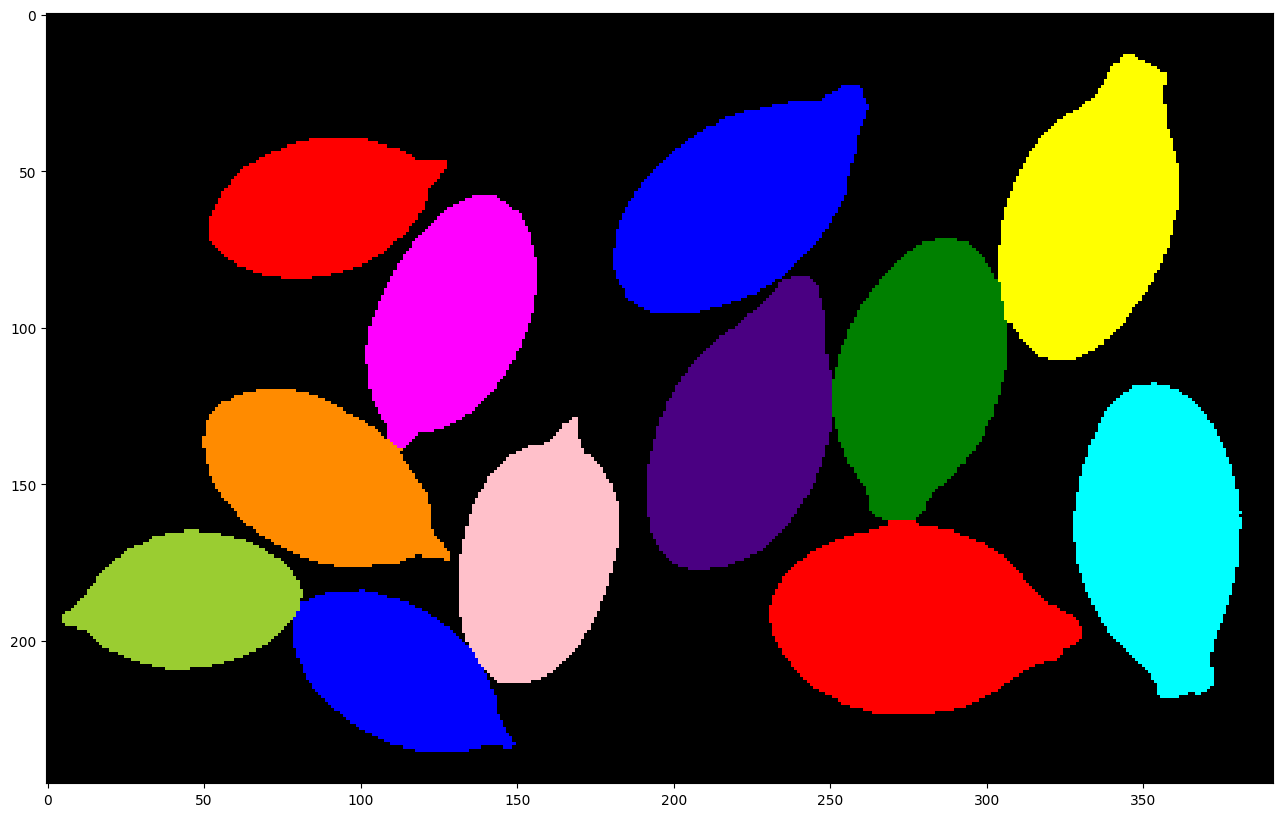

In [30]:
counting('seeds.jpg',235,255,0)